<a href="https://colab.research.google.com/github/nishikalewis/cs666student/blob/main/Copy_of_CS666_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

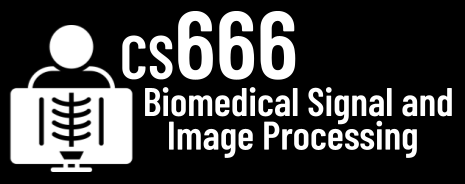
#Assignment 4

In [ ]:
# NAME: Nishika Divya Lewis

In [ ]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [1]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# we are using mahotas again, so lets install it!
!pip install mahotas --no-binary :all:

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: mahotas is being installed using the legacy 'setup.py install' method, because the '--no-binary' option was enabled for it and this currently disables local wheel building for projects that don't have a 'pyproject.toml' file. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussio

In [3]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [ ]:
# Please download this file: https://cs666.org/data/xray/
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
#
# TODO: Upload xray.zip using the file panel on the left.

In [98]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'


In [9]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

In [ ]:
# TODO: Please display this image and print the dimensions!

The dimensions of the image: (1858, 2090)


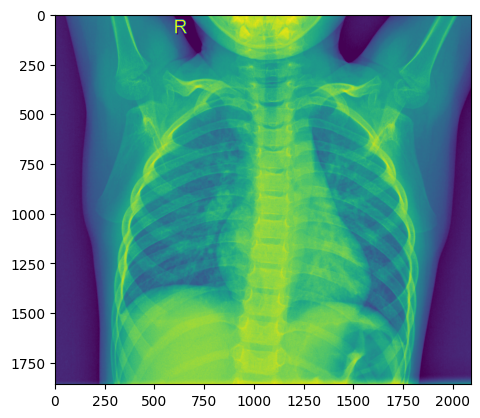

In [66]:
# TODO: YOUR CODE
imshow(img)
print ("The dimensions of the image:", img.shape)

**Task 2:** Let's do some data wrangling and more visualization! [35 Points]

In [17]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [19]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) Uses the os.listdir() method to generate a list of all files in the three folders NORMAL_DIR, PNEUMONIA_DIR, and COVID_DIR.
# TODO: Operation 2) Each loaded image is resized with dimensions (300, 300) using the mh.imresize() method before being placed to the relevant numpy array. If an RGB image has more than two dimensions, the code converts it to a grayscale image using the mh.colors.rgb2gray() method.
# TODO: Operation 3) The final piece of code uses slicing to allocate the resized and processed image to the respective location within the numpy array.

In [ ]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

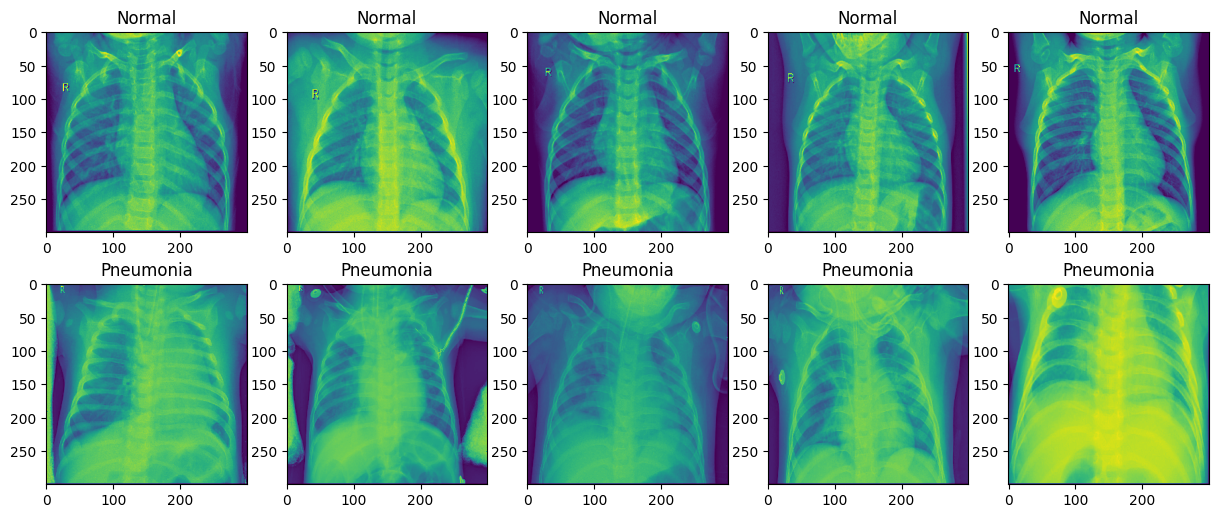

In [64]:
# TODO: YOUR CODE
import matplotlib.pyplot as plt

f, axa = plt.subplots(2,5, figsize=(15, 6))


for i, ax in enumerate(axa[0]):
    ax.imshow(data[0][i])
    ax.set_title('Normal')

for i, ax in enumerate(axa[1]):
    ax.imshow(data[1][i])
    ax.set_title('Pneumonia')

plt.show()

**Task 3:** Setup training and testing data. [15 Points]

In [39]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [91]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [92]:
# TODO: Please create the y_train vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_train = np.concatenate((np.zeros(TRAINING_COUNT), np.ones(TRAINING_COUNT), np.full(TRAINING_COUNT, 2)))

In [93]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [94]:
# TODO: Please create the y_test vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_test =np.concatenate((np.zeros(TESTING_COUNT), np.ones(TESTING_COUNT), np.full(TESTING_COUNT, 2)))

**Task 4:** Let's train and evaluate the Random Forest! [35 Points]

In [95]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [96]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [97]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is 
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [74]:
# TODO: In just a few sentences, please explain how the Random Forest works.

In [75]:
# TODO: Random Forest is a technique of Machine Learning. It simultaneously creates decision trees and computes their predictions. Each decision tree is constructed using a random subset of the features in the dataset. In this, we train on multiple images like normal, pneumonia and covid data.

In [76]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

1.0

In [77]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [78]:
# TODO: Yes, the classification accuracy is good as it is the maximum value. It shows that the predictions have no errors. So, I'm quite suprised as the model has predicted correctly for such small dataset.

**Bonus:** Let's take a closer look! [33 Points]

In [ ]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [100]:
# TODO: 
C_count= 99

X_ele= np.zeros( (C_count, 300*300 ), dtype=np.float32)
t_pos = 0

for image in data[2][100:199]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_ele[t_pos] = image
    t_pos += 1

In [101]:
y_ele = np.full(C_count, 2)
clf.score(X_ele, y_ele)

0.9696969696969697

In [106]:
# Can you figure out which images were misclassified?
# Hint: You can use predictions = clf.predict(X_test_covid_only) for this.
# Can you display them?

In [103]:
predictions = clf.predict(X_ele)

In [104]:
p_ele = np.where(y_ele != predictions)[0]
p_ele

array([15, 27, 84])

PROBLEMATIC IMAGES - 


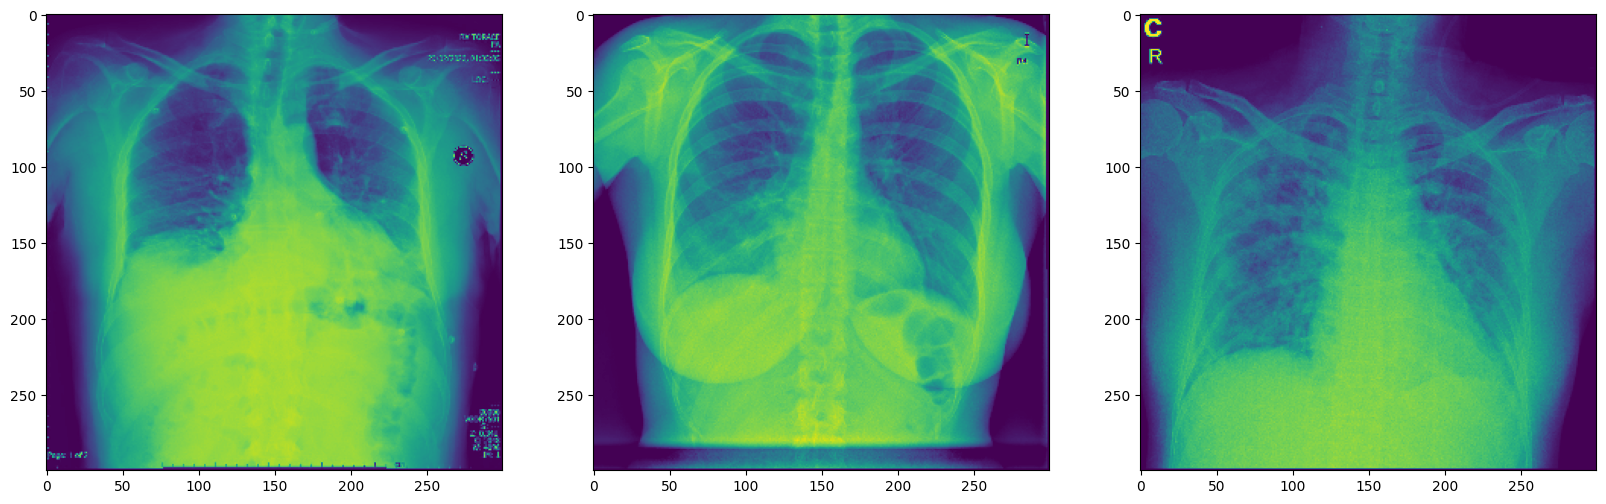

In [105]:
f, axarr = plt.subplots(1, 3, figsize=(20, 6))
print("PROBLEMATIC IMAGES - ")
axarr[0].imshow(data[2][100: ][p_ele[0]])
axarr[1].imshow(data[2][100: ][p_ele[1]])
axarr[2].imshow(data[2][100: ][p_ele[2]])

In [ ]:
# Do you have an idea why these images were problematic? 
# The images are problematic as they couldn't be classified accurately.

In [ ]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       

In [ ]:
#Collaboration with Samhitha Medi